In [3]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from icecream import ic
from pprint import pprint
from loguru import logger

dataset_path = "./../datasets/2023-09-30_20_percent_truncated_dataset.csv"

if not os.path.exists(dataset_path):
    logger.warning("Dataset not found!")

df = pd.read_csv(dataset_path)

print(f"Dataset shape (rows, cols): {df.shape}")

Dataset shape (rows, cols): (1470, 258)


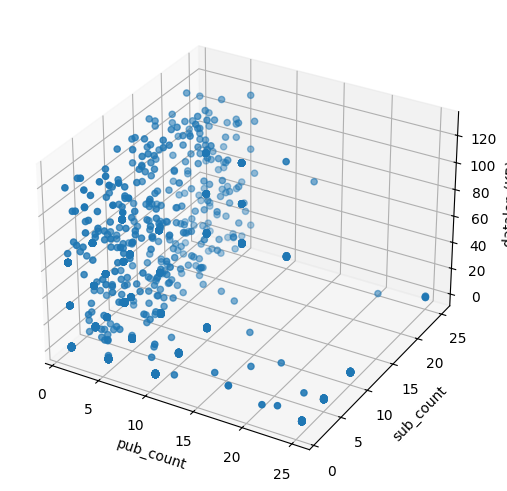

In [4]:

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(df['pub_count'], df['sub_count'], df['datalen_bytes']/1000, marker='o')
ax.set_xlabel('pub_count')
ax.set_ylabel('sub_count')
ax.set_zlabel('datalen (KB)')

plt.tight_layout()
plt.show()

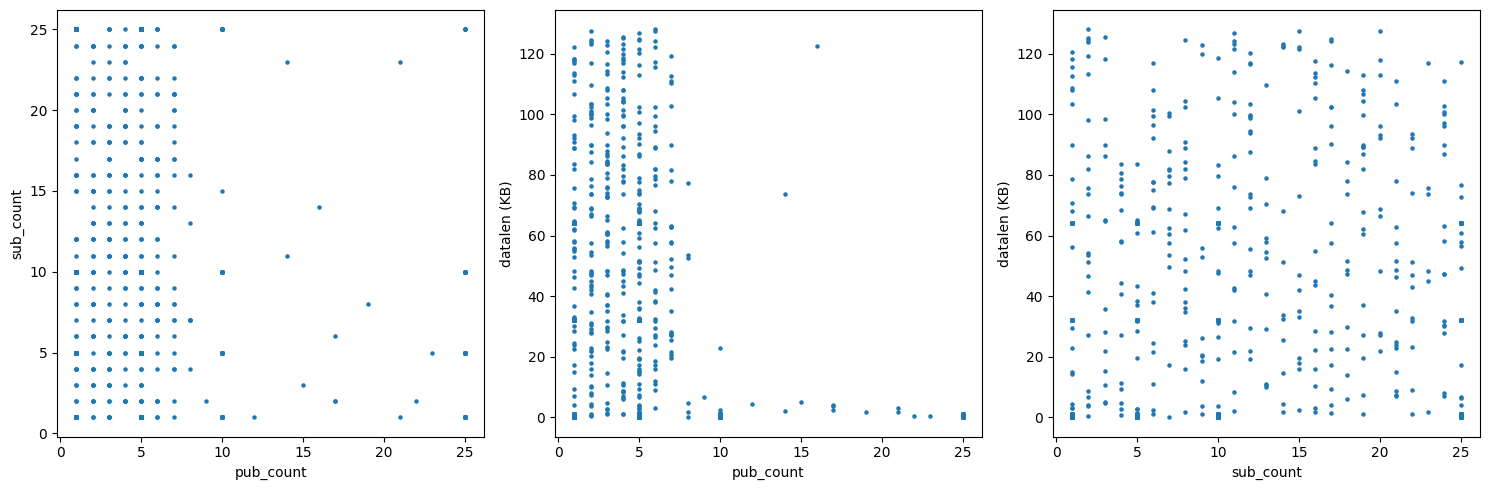

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(df['pub_count'], df['sub_count'], marker='o', s=5)
ax[0].set_xlabel('pub_count')
ax[0].set_ylabel('sub_count')

ax[1].scatter(df['pub_count'], df['datalen_bytes']/1000, marker='o', s=5)
ax[1].set_xlabel('pub_count')
ax[1].set_ylabel('datalen (KB)')

ax[2].scatter(df['sub_count'], df['datalen_bytes']/1000, marker='o', s=5)
ax[2].set_xlabel('sub_count')
ax[2].set_ylabel('datalen (KB)')

plt.tight_layout()
plt.show()

# Exploring Various Options for the Splitting of the Space

The idea is to specify some variable values and then look at the percentage in and out for each combination of values.

In [17]:
pub_counts = [5, 10, 15, 20, 25]
sub_counts = [5, 10, 15, 20, 25]
datalen_bytes = [40_000, 60_000, 80_000, 100_000, 120_000]

all_lists = [pub_counts, sub_counts, datalen_bytes]

# ? Cartesian product of all lists
combinations = itertools.product(*all_lists)
combinations = list(combinations)

grid_options = []

for comb in combinations:
    pub_count = comb[0]
    sub_count = comb[1]
    datalen = comb[2]

    # ? Get all values in df less than or equal to the values
    df_filtered = df[(df['pub_count'] <= pub_count) & (df['sub_count'] <= sub_count) & (df['datalen_bytes'] <= datalen)]
    in_percentage = len(df_filtered) / len(df) * 100
    out_percentage = 100 - in_percentage

    grid_options.append({
        'pub_count': pub_count,
        'sub_count': sub_count,
        'datalen': datalen,
        'in_count': len(df_filtered),
        'out_count': len(df) - len(df_filtered),
        'in_percentage': in_percentage,
        'out_percentage': out_percentage
    })

grid_df = pd.DataFrame(grid_options)
grid_df = grid_df.sort_values(by=['in_percentage'], ascending=False)

print(grid_df.to_markdown())

|     |   pub_count |   sub_count |   datalen |   in_count |   out_count |   in_percentage |   out_percentage |
|----:|------------:|------------:|----------:|-----------:|------------:|----------------:|-----------------:|
| 124 |          25 |          25 |    120000 |       1448 |          22 |         98.5034 |          1.4966  |
| 123 |          25 |          25 |    100000 |       1400 |          70 |         95.2381 |          4.7619  |
| 122 |          25 |          25 |     80000 |       1348 |         122 |         91.7007 |          8.29932 |
|  99 |          20 |          25 |    120000 |       1335 |         135 |         90.8163 |          9.18367 |
|  74 |          15 |          25 |    120000 |       1331 |         139 |         90.5442 |          9.45578 |
|  49 |          10 |          25 |    120000 |       1327 |         143 |         90.2721 |          9.72789 |
|  98 |          20 |          25 |    100000 |       1287 |         183 |         87.551  |         12.

Let's narrow it down to values where the in_percentage is between 75 to 85%.

In [18]:
# ? Limit grid_df to values where in_percentage is between 75 and 85
filtered_grid_df = grid_df[(grid_df['in_percentage'] >= 75) & (grid_df['in_percentage'] <= 85)]

print(filtered_grid_df.to_markdown())

|     |   pub_count |   sub_count |   datalen |   in_count |   out_count |   in_percentage |   out_percentage |
|----:|------------:|------------:|----------:|-----------:|------------:|----------------:|-----------------:|
|  97 |          20 |          25 |     80000 |       1235 |         235 |         84.0136 |          15.9864 |
|  72 |          15 |          25 |     80000 |       1231 |         239 |         83.7415 |          16.2585 |
|  47 |          10 |          25 |     80000 |       1227 |         243 |         83.4694 |          16.5306 |
| 119 |          25 |          20 |    120000 |       1145 |         325 |         77.8912 |          22.1088 |
|  24 |           5 |          25 |    120000 |       1125 |         345 |         76.5306 |          23.4694 |
| 118 |          25 |          20 |    100000 |       1104 |         366 |         75.102  |          24.898  |


Let's narrow it down to between 76 and 84.

In [20]:
further_filtered_grid_df = grid_df[(grid_df['in_percentage'] >= 76) & (grid_df['in_percentage'] <= 84)]

print(further_filtered_grid_df.to_markdown())

|     |   pub_count |   sub_count |   datalen |   in_count |   out_count |   in_percentage |   out_percentage |
|----:|------------:|------------:|----------:|-----------:|------------:|----------------:|-----------------:|
|  72 |          15 |          25 |     80000 |       1231 |         239 |         83.7415 |          16.2585 |
|  47 |          10 |          25 |     80000 |       1227 |         243 |         83.4694 |          16.5306 |
| 119 |          25 |          20 |    120000 |       1145 |         325 |         77.8912 |          22.1088 |
|  24 |           5 |          25 |    120000 |       1125 |         345 |         76.5306 |          23.4694 |


From the above table I am going to eliminate the last row (with 5 pubs, 25 subs, and 120KB) because 5 pubs is too small and doesn't cover enough space in the pub_count.

In [22]:
further_filtered_grid_df_2 = further_filtered_grid_df.iloc[:-1]

print(further_filtered_grid_df_2.to_markdown())

|     |   pub_count |   sub_count |   datalen |   in_count |   out_count |   in_percentage |   out_percentage |
|----:|------------:|------------:|----------:|-----------:|------------:|----------------:|-----------------:|
|  72 |          15 |          25 |     80000 |       1231 |         239 |         83.7415 |          16.2585 |
|  47 |          10 |          25 |     80000 |       1227 |         243 |         83.4694 |          16.5306 |
| 119 |          25 |          20 |    120000 |       1145 |         325 |         77.8912 |          22.1088 |


I'm going to eliminate the last row again because it covers all pub counts (25).

In [24]:
further_filtered_grid_df_3 = further_filtered_grid_df_2.iloc[:-1]

print(further_filtered_grid_df_3.to_markdown())

|    |   pub_count |   sub_count |   datalen |   in_count |   out_count |   in_percentage |   out_percentage |
|---:|------------:|------------:|----------:|-----------:|------------:|----------------:|-----------------:|
| 72 |          15 |          25 |     80000 |       1231 |         239 |         83.7415 |          16.2585 |
| 47 |          10 |          25 |     80000 |       1227 |         243 |         83.4694 |          16.5306 |


I'm going to pick the one closest to the 80-20 split which is the last row with 10 pubs, 25 subs, and 80KB.

In [33]:
chosen_grid_df = further_filtered_grid_df_3.iloc[-1]


I'm going to draw the scatter plots for the chosen boundaries.

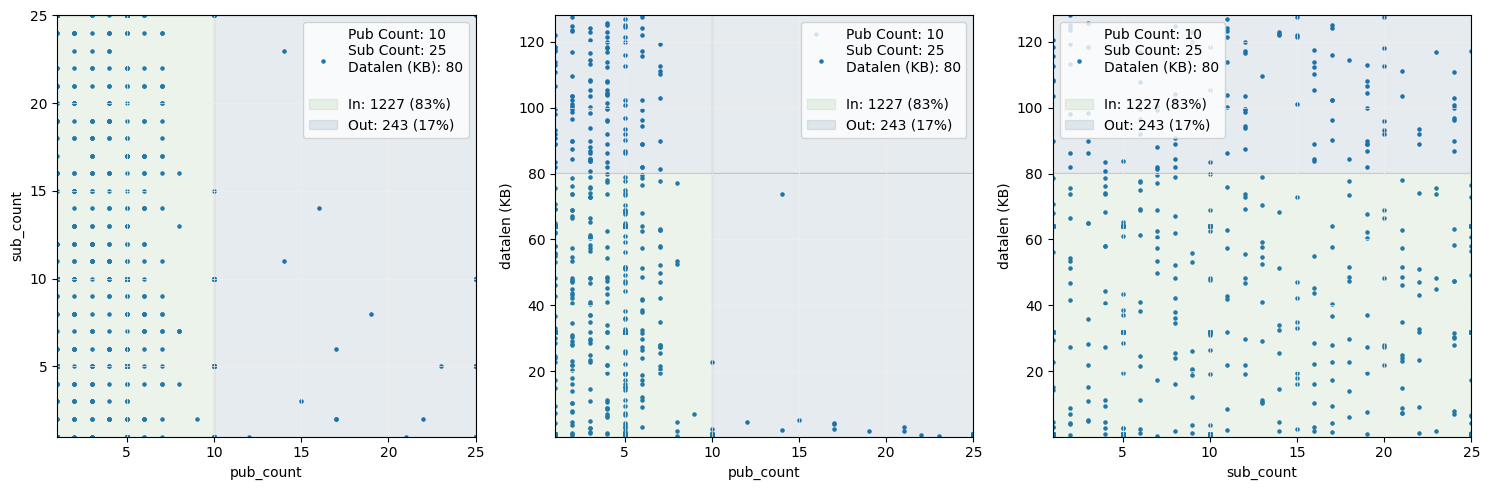

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5 * 1))

pub_count = int(chosen_grid_df['pub_count'])
sub_count = int(chosen_grid_df['sub_count'])
datalen_kb = int(chosen_grid_df['datalen'] / 1000)

min_pub_count = df['pub_count'].min()
max_pub_count = df['pub_count'].max()
min_sub_count = df['sub_count'].min()
max_sub_count = df['sub_count'].max()
min_datalen = df['datalen_bytes'].min()
max_datalen = df['datalen_bytes'].max()

ax = axs[0]
ax.scatter(df['pub_count'], df['sub_count'], marker='o', s=5, label=f"Pub Count: {pub_count}\nSub Count: {sub_count}\nDatalen (KB): {datalen_kb}\n")
ax.set_xlabel('pub_count')
ax.set_ylabel('sub_count')
ax.axvspan(
    0, 
    pub_count, 
    ymin=0, 
    ymax=sub_count / max_sub_count, 
    color='#488f31', 
    alpha=0.1, 
    label=f'In: { int( chosen_grid_df["in_count"] ) } ({ int( round(chosen_grid_df["in_percentage"], 0) ) }%)'
)
ax.axvspan(
    pub_count,
    max_pub_count,
    ymin=sub_count / max_sub_count, 
    ymax=max_sub_count, 
    color='#003f5c', 
    alpha=0.1, 
    label=f'Out: { int( chosen_grid_df["out_count"] ) } ({ int( round(chosen_grid_df["out_percentage"], 0) ) }%)'
)
ax.axvspan(
    0,
    pub_count,
    ymin=sub_count / max_sub_count, 
    ymax=max_sub_count, 
    color='#003f5c', 
    alpha=0.1,
)
ax.axvspan(
    pub_count,
    max_pub_count,
    ymin=0,
    ymax=sub_count / max_sub_count,
    color='#003f5c',
    alpha=0.1,
)
ax.set_xlim(min_pub_count, max_pub_count)
ax.set_ylim(min_sub_count, max_sub_count)
ax.legend()

ax = axs[1]
ax.scatter(df['pub_count'], df['datalen_bytes']/1000, marker='o', s=5, label=f"Pub Count: {pub_count}\nSub Count: {sub_count}\nDatalen (KB): {datalen_kb}\n")
ax.set_xlabel('pub_count')
ax.set_ylabel('datalen (KB)')
ax.axvspan(
    0, 
    pub_count, 
    ymin=0, 
    ymax=(datalen_kb * 1000) / max_datalen, 
    color='#488f31', 
    alpha=0.1, 
    label=f'In: { int( chosen_grid_df["in_count"] ) } ({ int( round(chosen_grid_df["in_percentage"], 0) ) }%)'
)
ax.axvspan(
    pub_count,
    max_pub_count,
    ymin=(datalen_kb * 1000) / max_datalen, 
    ymax=max_datalen, 
    color='#003f5c', 
    alpha=0.1, 
    label=f'Out: { int( chosen_grid_df["out_count"] ) } ({ int( round(chosen_grid_df["out_percentage"], 0) ) }%)'
)
ax.axvspan(
    0,
    pub_count,
    ymin=(datalen_kb * 1000) / max_datalen, 
    ymax=max_datalen, 
    color='#003f5c', 
    alpha=0.1,
)
ax.axvspan(
    pub_count,
    max_pub_count,
    ymin=0,
    ymax=(datalen_kb * 1000) / max_datalen,
    color='#003f5c',
    alpha=0.1,
)
ax.set_xlim(min_pub_count, max_pub_count)
ax.set_ylim(min_datalen / 1000, max_datalen / 1000)
ax.legend()

ax = axs[2]
ax.scatter(df['sub_count'], df['datalen_bytes']/1000, marker='o', s=5, label=f"Pub Count: {pub_count}\nSub Count: {sub_count}\nDatalen (KB): {datalen_kb}\n")
ax.set_xlabel('sub_count')
ax.set_ylabel('datalen (KB)')
ax.axvspan(
    0, 
    sub_count, 
    ymin=0, 
    ymax=(datalen_kb * 1000) / max_datalen, 
    color='#488f31', 
    alpha=0.1, 
    label=f'In: { int( chosen_grid_df["in_count"] ) } ({ int( round(chosen_grid_df["in_percentage"], 0) ) }%)'
)
ax.axvspan(
    sub_count,
    max_sub_count,
    ymin=(datalen_kb * 1000) / max_datalen, 
    ymax=max_datalen, 
    color='#003f5c', 
    alpha=0.1, 
    label=f'Out: { int( chosen_grid_df["out_count"] ) } ({ int( round(chosen_grid_df["out_percentage"], 0) ) }%)'
)
ax.axvspan(
    0,
    sub_count,
    ymin=(datalen_kb * 1000) / max_datalen, 
    ymax=max_datalen, 
    color='#003f5c', 
    alpha=0.1,
)
ax.axvspan(
    sub_count,
    max_sub_count,
    ymin=0,
    ymax=(datalen_kb * 1000) / max_datalen,
    color='#003f5c',
    alpha=0.1,
)
ax.set_xlim(min_sub_count, max_sub_count)
ax.set_ylim(min_datalen / 1000, max_datalen / 1000)
ax.legend()

for ax in axs.flat:
    ax.grid(True, linewidth=0.5, color='#efefef')

plt.tight_layout()
plt.show()

Therefore, here are the choices for the limiting values:

- Pub Count: 10
- Sub Count: 25
- Data Length (KB): 80

# Creating the interpolation and extrapolation datasets

Now that the ranges have been chosen, it's time to create 2 csv files:
- Train Dataset (used in both interpolation and extrapolation)
- Extrapolation Test Dataset (used for testing extrapolation)

I want to make sure that the number of examples used for training and testing is the same for both interpolation and extrapolation. With that in mind, when I test for interpolation I need to sample the same number of rows as what is in the extrapolation test dataset.

In [37]:
chosen_pub = 10
chosen_sub = 25
chosen_datalen = 80_000

inside_df = df[(df['pub_count'] <= chosen_pub) & (df['sub_count'] <= chosen_sub) & (df['datalen_bytes'] <= chosen_datalen)].reset_index(drop=True)
outside_df = df[(df['pub_count'] > chosen_pub) | (df['sub_count'] > chosen_sub) | (df['datalen_bytes'] > chosen_datalen)].reset_index(drop=True)

print(f"Inside df shape (rows, cols): {inside_df.shape}")
print(f"Outside df shape (rows, cols): {outside_df.shape}")

train_dataset = inside_df
extrapolation_test_dataset = outside_df

import datetime
current_date = datetime.date.today()
formatted_date = current_date.strftime("%Y-%m-%d")

train_dataset.to_csv(f"./../datasets/{formatted_date}_train_dataset.csv", index=False)
extrapolation_test_dataset.to_csv(f"./../datasets/{formatted_date}_extrapolation_test_dataset.csv", index=False)

print(f"Train dataset saved to ./../datasets/{formatted_date}_train_dataset.csv")
print(f"Extrapolation test dataset saved to ./../datasets/{formatted_date}_extrapolation_test_dataset.csv")

Inside df shape (rows, cols): (1227, 258)
Outside df shape (rows, cols): (243, 258)
Train dataset saved to ./../datasets/2023-09-30_train_dataset.csv
Extrapolation test dataset saved to ./../datasets/2023-09-30_extrapolation_test_dataset.csv
